# Импортируем библиотеки и загружаем данные

In [ ]:
import pandas as pd
import gdown
import ast
import json
import numpy as np
import requests
from datetime import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
# !pip install pymorphy2
import pymorphy2
from scipy import stats
# !pip install sweetviz
import sweetviz as sv
# !pip uninstall pandas_profiling
import pandas_profiling
from matplotlib import pyplot

In [ ]:
# Загружаем таблицу с гугл-диска
url = '15_FfenvHFoJVcPu6gGx9osLn71uDJ-Et'
output = "vacancies.csv"
gdown.download('https://drive.google.com/uc?export=download&id=' + url, output, quiet=False)

In [78]:
df = pd.read_csv("vacancies.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Исследуем переменные



In [79]:
# Удаляем идентичные столбцы
cols = ['billing_type_id', 'experience_id', 'employment_id', 'alternate_url', 'schedule_id', 'area_url', 'working_time_modes_id', 'type_id']
for col in cols:
  del df[col]

In [80]:
# Получаем все города и их parent_id
req = requests.get('https://api.hh.ru/areas')  # Посылаем запрос к API
data = req.content.decode()  # Декодируем его ответ, чтобы Кириллица отображалась корректно
req.close()
jsonObj = json.loads(data)
cities, countries_name, areas_name = [], [], []
for i in range(len(jsonObj)):
    for area in jsonObj[i]['areas']:
      if area['areas'] == []:
        cities.append(area)
        countries_name.append(jsonObj[i]['name'])
        areas_name.append(area['name'])
      else:
        for city in area['areas']:
          cities.append(city)
          countries_name.append(jsonObj[i]['name'])
          areas_name.append(area['name'])
df_cities = pd.DataFrame(cities)
df_cities['country_name'] = countries_name
df_cities['areas_name'] = areas_name

In [83]:
# Переименовываем столбец
df_cities['area_id'] = df_cities['id']
df_cities = df_cities.drop('id', 1)

In [84]:
# Конвертируем в формат int, чтобы сопоставить
df_cities['area_id'] = df_cities['area_id'].astype(str).astype(int)

In [85]:
# Присваиваем каждой строке имя региона и страны
df['areas_name'] = df['area_id'].map(df_cities.set_index('area_id')['areas_name'])
df['country_name'] = df['area_id'].map(df_cities.set_index('area_id')['country_name'])

In [86]:
# Считаем среднюю з/п
df['salary_avg'] = (df['salary_from'] + df['salary_to'])/2

In [87]:
# Вместо списка делаем множество (т.к. значения в списке повторяются)
cols = ['specializations_profarea_name', 'specializations_name']
for col in cols:
  df[col] = df[col].apply(lambda x: set(eval(x))).astype(str)

In [ ]:
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
report.show_html('common analysis.html')

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
profile = pandas_profiling.ProfileReport(df)

In [ ]:
profile

default


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/basic.py:300: UserWarning: %profile is now deprecated. Please use get_ipython().profile instead.
  warn("%profile is now deprecated. Please use get_ipython().profile instead.")


# Зарплата

In [ ]:
# Для тех вакансий, у которых з/п указана после вычета налогов делаем ее до вычетов
df['salary_avg'][(df['salary_gross'] == False) & ((df['country_name'] == 'Россия') | (df['country_name'] == 'Беларусь'))] = df['salary_avg']/0.87
df['salary_avg'][(df['salary_gross'] == False) & ((df['country_name'] == 'Казахстан') | (df['country_name'] == 'Кыргызстан'))] = df['salary_avg']/0.9
df['salary_avg'][(df['salary_gross'] == False) & (df['country_name'] == 'Украина')] = df['salary_avg']/0.82
df['salary_avg'][(df['salary_gross'] == False) & (df['country_name'] == 'Грузия')] = df['salary_avg']/0.8

In [92]:
%matplotlib inline

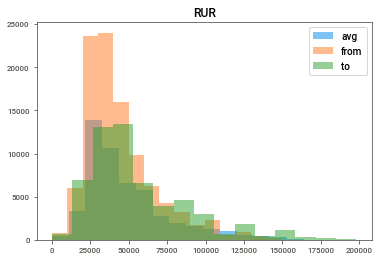

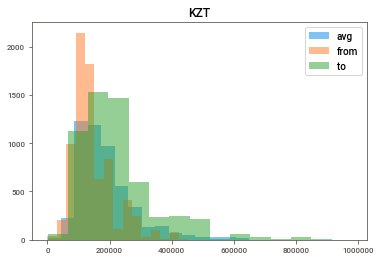

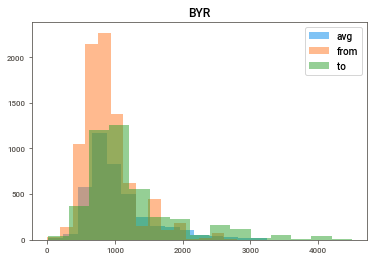

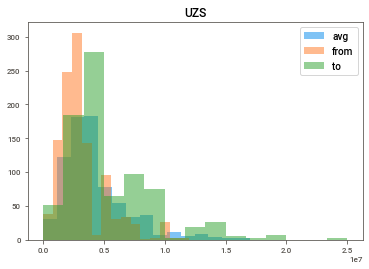

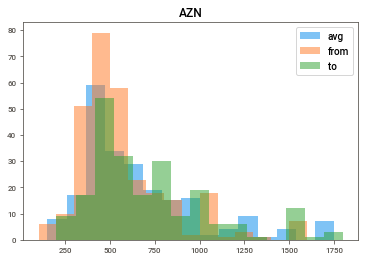

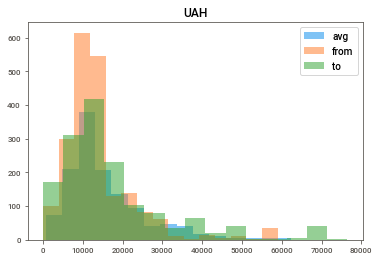

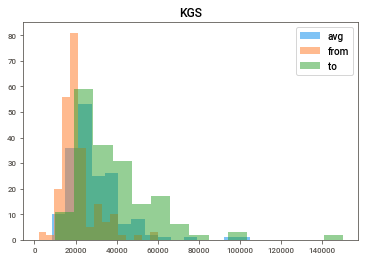

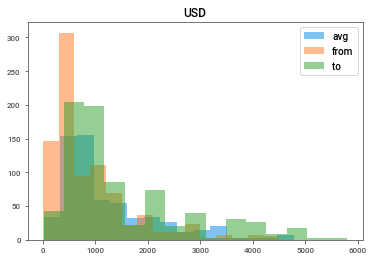

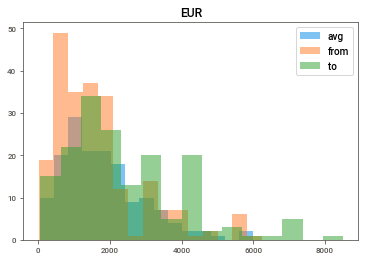

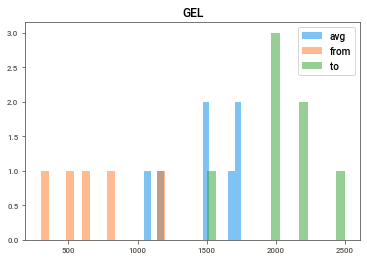

In [93]:
# Рисуем гистограммы распределения з/п для каждой валюты
for currency in df['salary_currency'].dropna().unique():
  Q99_from = np.nanpercentile(df['salary_from'][df['salary_currency'] == currency], 99)
  Q99_to = np.nanpercentile(df['salary_to'][df['salary_currency'] == currency], 99)
  Q99_avg = np.nanpercentile(df['salary_avg'][df['salary_currency'] == currency], 99)
  pyplot.hist(df['salary_avg'][df['salary_avg'] < Q99_avg][df['salary_currency'] == currency], bins = 15, alpha=0.5, label='avg')
  pyplot.hist(df['salary_from'][df['salary_from'] < Q99_from][df['salary_currency'] == currency], bins = 15, alpha=0.5, label='from')
  pyplot.hist(df['salary_to'][df['salary_to'] < Q99_to][df['salary_currency'] == currency],bins = 15, alpha=0.5, label='to')
  pyplot.legend(loc='upper right')
  pyplot.title(currency)
  pyplot.show()

In [ ]:
# Подгружаем данные росстата по з/п с гугл-диска
url = '1mfzAkO00BX506VF-_yk_05r5iO72j6Y3'
output = "salary_gks.xlsx"
gdown.download('https://drive.google.com/uc?export=download&id=' + url, output, quiet=False)
df_gks = pd.read_excel(output)

In [95]:
# Считаем средние з/п по всем регионам
x = pd.DataFrame(df[df['country_name'] == 'Россия']['salary_avg'].groupby(df['areas_name']).mean())
x['areas_name'] = x.index

In [96]:
x['salary_gks'] = x['areas_name'].map(df_gks.set_index('areas_name')['salary_avg'])

In [97]:
# Считаем, насколько посчитанная средняя зарплата отличается от данных с росстата за июнь в рублях
(abs(x['salary_gks'] - x['salary_avg'])).mean()

9889.62837069714

In [98]:
# Корреляция
x['salary_gks'].corr(x['salary_avg'])

0.8181684244787355

In [99]:
x = x.dropna()
stats.ttest_ind(x['salary_avg'],x['salary_gks']) # p-value > 0.05, значит принимаем нулевую гипотезу, 2 independent samples have identical average (expected) values

Ttest_indResult(statistic=-0.7503911509817973, pvalue=0.4540943932967555)

In [100]:
# Описательная статистика для з/п
for curr in df['salary_currency'].dropna().unique():
  print(f'\n\t\t{curr}\n')
  x = df[(df['salary_currency'] == curr)].describe()[['salary_from', 'salary_to', 'salary_avg']]
  s = x.style.format(formatter = '{:,.0f}')
  display(s)


		RUR



,salary_from,salary_to,salary_avg
count,"101,182","57,546","50,956"
mean,"44,008","59,099","50,413"
std,"31,296","45,509","34,587"
min,1,1,1
25%,"25,342","32,000","30,000"
50%,"35,000","46,000","40,000"
75%,"50,000","70,000","60,000"
max,"1,000,000","1,700,000","1,100,000"



		KZT



,salary_from,salary_to,salary_avg
count,"7,817","5,695","5,064"
mean,"157,133","239,985","196,510"
std,"91,546","195,494","131,213"
min,70,650,600
25%,"100,000","150,000","125,000"
50%,"140,000","200,000","165,000"
75%,"185,000","300,000","225,000"
max,"1,500,000","5,000,000","2,600,000"



		BYR



,salary_from,salary_to,salary_avg
count,"8,732","4,389","4,021"
mean,927,"1,323","1,106"
std,642,"1,233",968
min,1,15,15
25%,650,800,750
50%,800,"1,000",900
75%,"1,000","1,500","1,250"
max,"40,000","50,000","45,000"



		UZS



,salary_from,salary_to,salary_avg
count,"1,123",826,773
mean,"3,403,726","5,924,555","4,520,952"
std,"2,538,675","4,570,344","3,227,409"
min,1,1,1
25%,"2,000,000","3,000,000","2,500,000"
50%,"3,000,000","5,000,000","3,750,000"
75%,"4,000,000","8,000,000","5,500,000"
max,"25,000,000","30,000,000","25,000,000"



		AZN



,salary_from,salary_to,salary_avg
count,295,227,227
mean,544,802,682
std,313,454,390
min,100,200,150
25%,400,500,450
50%,500,700,550
75%,600,"1,000",800
max,"2,500","3,500","3,000"



		UAH



,salary_from,salary_to,salary_avg
count,"2,075","1,545","1,321"
mean,"14,522","19,232","17,382"
std,"12,044","16,792","13,614"
min,25,12,700
25%,"8,300","9,400","9,500"
50%,"12,000","14,000","13,000"
75%,"15,300","24,000","21,000"
max,"150,000","150,000","130,000"



		KGS



,salary_from,salary_to,salary_avg
count,244,184,172
mean,"21,993","39,762","30,339"
std,"11,184","26,594","17,239"
min,"2,000","10,000","8,500"
25%,"15,000","25,000","20,875"
50%,"20,000","31,000","27,000"
75%,"25,000","47,000","35,000"
max,"100,000","200,000","135,000"



		USD



,salary_from,salary_to,salary_avg
count,869,787,622
mean,"1,101","1,824","1,488"
std,"2,928","4,599","4,015"
min,1,15,14
25%,400,600,550
50%,600,"1,000",850
75%,"1,200","2,000","1,750"
max,"70,000","90,000","80,000"



		EUR



,salary_from,salary_to,salary_avg
count,228,171,162
mean,"2,655","2,551","2,019"
std,"10,689","1,876","1,449"
min,8,60,35
25%,615,"1,375","1,081"
50%,"1,380","2,000","1,700"
75%,"2,000","3,311","2,560"
max,"150,000","10,000","8,125"



		GEL



,salary_from,salary_to,salary_avg
count,8,8,8
mean,988,"2,175","1,581"
std,497,437,378
min,300,"1,500","1,050"
25%,575,"2,000","1,412"
50%,"1,000","2,100","1,600"
75%,"1,500","2,275","1,750"
max,"1,500","3,000","2,250"


# Анализируем описание вакансий

In [109]:
# Избавляемся от html-кода в столбце 'description'
code = ['<li>', '</li>', '<strong>', '</strong>','<p>', '</p>','<ul>', '</ul>','&quot', '<em>', '<br />']
for word in code:
  df['description'] = df['description'].str.replace(word, '')

In [110]:
# Считаем наиболее часто встречающиеся слова в описании вакансий, за исключением stopwords и небуквенных символов
s = df['description'].to_string()

In [111]:
allWords = nltk.tokenize.word_tokenize(s)
stopwords = nltk.corpus.stopwords.words('russian')

In [112]:
symbols = ['<', '>', '...', ',', '-', '.', ';', ':', '«', '»', '!', '(', ')', '/', '–', '—', '&']

In [113]:
morph = pymorphy2.MorphAnalyzer()

In [114]:
allWordExceptStopDist = nltk.FreqDist(morph.parse(w.lower())[0].normal_form for w in allWords if w.lower() not in symbols and w.lower() not in stopwords)   

In [115]:
mostCommon = Counter(allWordExceptStopDist).most_common(15)

In [116]:
mostCommon

[('обязанность', 73627),
 ('работа', 21256),
 ('компания', 17398),
 ('требоваться', 7782),
 ('крупный', 7105),
 ('сеть', 6736),
 ('приглашать', 5743),
 ('магазин', 4566),
 ('работать', 4112),
 ('приём', 4081),
 ('команда', 4010),
 ('хотеть', 3895),
 ('организация', 3785),
 ('ооо', 3719),
 ('клиент', 3718)]